In [1]:
!pip install deepxde

     |████████████████████████████████| 111 kB 5.3 MB/s 
     |████████████████████████████████| 101 kB 10.3 MB/s 


**Schrodinger-like equation wih Poschl-Teller potential & complex-valued quasinormal modes (forward problem):**



**Results**: Psi_n(y), ... n = 0, 1, 2, 3. ... & ... (-0.9 < y < 0.9)

________________________________________________________________________________

1. Omega_0 = 0.5 - i(0 + 0.5), ... psi_0(y) vs PINN approximation.

Re[psi] L2 relative error: 2.4392475e-05

Im[psi] L2 relative error: 0.00034558025

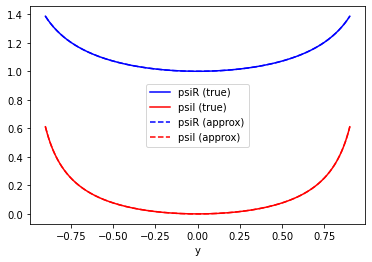

______________________________________________________________________________

2. Omega_1 = 0.5 - i(1 + 0.5), ... psi_1(y) vs PINN approximation.

Re[psi] L2 relative error: 0.000113852584

Im[psi] L2 relative error: 0.00033774535

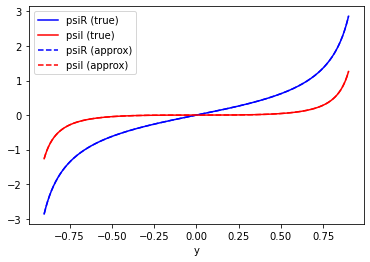

________________________________________________________________________________

3. Omega_2 = 0.5 - i(2 + 0.5), ... psi_2(y) vs PINN approximation.

Re[psi] L2 relative error: 0.0018091063

Im[psi] L2 relative error: 0.0025194862

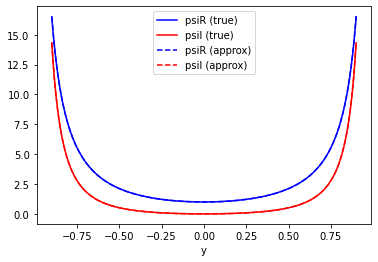
________________________________________________________________________________

4. Omega_3 = 0.5 - i(3 + 0.5), ... psi_3(y) vs PINN approximation.

Re[psi] L2 relative error: 0.003179616

Im[psi] L2 relative error: 0.0033014105

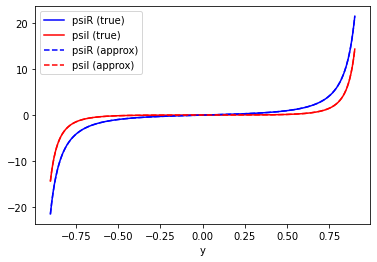



Deepxde backend not selected or invalid. Assuming tensorflow.compat.v1 for now.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDEBACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch (all lowercase)
Instructions for updating:
non-resource variables are not supported in the long term

Compiling model...
Building feed-forward neural network...
'build' took 0.065327 s

'compile' took 0.955163 s

Initializing variables...
Training model...

Step      Train loss                                                      Test loss                                                       Test metric   
0         [1.53e+01, 6.01e-02, 2.73e+02, 2.73e+02, 2.06e+02, 2.06e+02]    [1.49e+01, 6.12e-02, 2.73e+02, 2.73e+02, 2.06e+02, 2.06e+02]    [1.00e+00]    
1000      [7.17e-01, 1.80e+00, 1.28e+00, 1.28e+00, 3.40e-01, 3.40e-01]    [2.84e+00, 6.98e+00, 1.28e+00, 1.28e+00, 3.40e-01, 3.40e-01]    [5.92e-02]    
INFO:tensorflow:/content/model/model.ckpt-1000 is not in all_model_

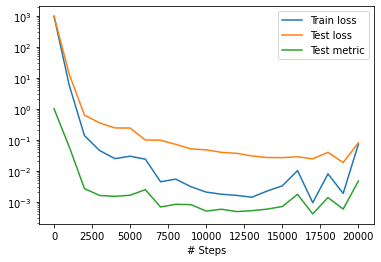

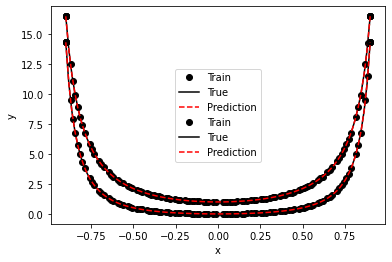

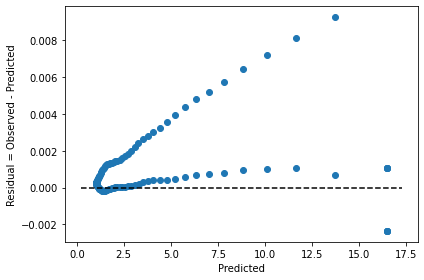

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Sun 09/05/2021
Last updated Mon 10/05/2021

"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import io
import re

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cmath
import math
import deepxde as dde
from deepxde.backend import tf

import matplotlib.pyplot as plt

N = 2
omegaR = 0.5 ### omega = omegaR + omegaI*1j or omega = Re[omega] + Im[omega]*i
omegaI =-2.5
Dom_points = 100
        
def de(y, psi):
        psiR, psiI = psi[:, 0:1], psi[:, 1:2] ### psiR = Re[psi]. psiI = Im[psi]
        dpsiR_y = dde.grad.jacobian(psi, y, i=0)
        dpsiI_y = dde.grad.jacobian(psi, y, i=1)
        dpsiR_yy = dde.grad.hessian(psi, y, component=0, i=0, j=0)
        dpsiI_yy = dde.grad.hessian(psi, y, component=1, i=0, j=0)


        return [((1 - y**2)**2)*dpsiR_yy - 2 * y *(1 - y**2) * dpsiR_y - ((1 - y**2)/2) * psiR - 2*omegaI*omegaR*psiI + (omegaR**2 - omegaI**2)*psiR ,
                ((1 - y**2)**2)*dpsiI_yy - 2 * y *(1 - y**2) * dpsiI_y - ((1 - y**2)/2) * psiI + 2*omegaI*omegaR*psiR + (omegaR**2 - omegaI**2)*psiI ,
                
        ]

### I used Mathematica to check these solutions: i.e. that they give zero on the RHS of the differential equations when plugged in.

def func(y):### Real part of psi (true solution)
  SolDict = {'N_0' : (1 - y**2)**(-1/4 - 1j/4),
         'N_1' : y*(1 - y**2)**(-3/4 - 1j/4),
         'N_2' : (1 + ((3 + 1j)*y**2)/(1 - y**2))*(1 - y**2)**(-1/4 - 1j/4),
         'N_3' : (((5/3 + 1j/3)*y**3)/((1 - y**2)**(3/2)) + y/((1 - y**2)**(1/2)))*(1 - y**2)**(-1/4 - 1j/4),
         }
        
  real = np.real(SolDict['N_{}'.format(N)])
  imag = np.imag(SolDict['N_{}'.format(N)])
  return np.hstack((real, imag))

def func1(y):### Real part of psi (true solution)
  SolDict = {'N_0' : (1 - y**2)**(-1/4 - 1j/4),
         'N_1' : y*(1 - y**2)**(-3/4 - 1j/4),
         'N_2' : (1 + ((3 + 1j)*y**2)/(1 - y**2))*(1 - y**2)**(-1/4 - 1j/4),
         'N_3' : (((5/3 + 1j/3)*y**3)/((1 - y**2)**(3/2)) + y/((1 - y**2)**(1/2)))*(1 - y**2)**(-1/4 - 1j/4),
         }
        
  sol1 = np.real(SolDict['N_{}'.format(N)])
  return sol1


def func2(y):### Imaginary part of psi (true solution)
  SolDict = {'N_0' : (1 - y**2)**(-1/4 - 1j/4),
         'N_1' : y*(1 - y**2)**(-3/4 - 1j/4),
         'N_2' : (1 + ((3 + 1j)*y**2)/(1 - y**2))*(1 - y**2)**(-1/4 - 1j/4),
         'N_3' : (((5/3 + 1j/3)*y**3)/((1 - y**2)**(3/2)) + y/((1 - y**2)**(1/2)))*(1 - y**2)**(-1/4 - 1j/4),
         }
        
  sol2 = np.imag(SolDict['N_{}'.format(N)])
  return sol2 


def boundary_l(x, on_boundary):
        return on_boundary and np.isclose(x[0], -0.9) 
def boundary_r(x, on_boundary):
        return on_boundary and np.isclose(x[0], 0.9) 

geom = dde.geometry.Interval(-0.9, 0.9) ### Just define a 1D spacial domain

bc1 = dde.DirichletBC(geom, func1, lambda _, boundary_l : boundary_l, component=0) 
bc2 = dde.DirichletBC(geom, func1, lambda _, boundary_r : boundary_r, component=0)
bc3 = dde.DirichletBC(geom, func2, lambda _, boundary_l : boundary_l, component=1) 
bc4 = dde.DirichletBC(geom, func2, lambda _, boundary_r : boundary_r, component=1)

data = dde.data.PDE(
        geom,
        de,
        [bc1, bc2, bc3, bc4],
        num_domain=Dom_points,
        num_boundary=2,
        solution= func,
        num_test= 100,
    )

checkpoint_filepath = "/content/model/model.ckpt"
model_checkpoint_callback = dde.callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,
save_better_only=False,
period=1000)

layer_size = [1] + [20] * 3  + [2]
net = dde.maps.FNN(layer_size, "tanh", "Glorot uniform")
model = dde.Model(data, net)
                    
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=20000, callbacks=[model_checkpoint_callback]) 
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Restoring model from /content/model/model.ckpt-20000 ...

INFO:tensorflow:Restoring parameters from /content/model/model.ckpt-20000


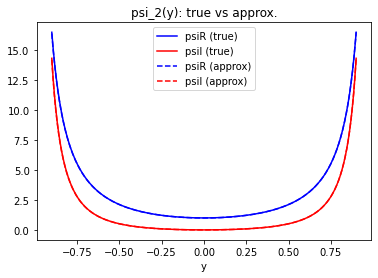

L2 relative error: 0.0032742356
L2 relative error: 0.005412251


In [3]:
###Plotting the model that has the least l2 relative error
model.restore( "/content/model/model.ckpt-20000", verbose=1)
y = geom.uniform_points(2500, True)
Y1 = model.predict(y)[:, 0:1]
Y2 = model.predict(y)[:, 1:2]
ytrue1 = func1(y)
ytrue2 = func2(y)
plt.figure()
plt.plot(y, ytrue1,"-b", label="psiR (true)")
plt.plot(y, ytrue2,"-r", label="psiI (true)")
plt.plot(y, Y1,"--b", label="psiR (approx)")
plt.plot(y, Y2,"--r", label="psiI (approx)")
plt.title("psi_2(y): true vs approx.")
plt.xlabel("y")
plt.legend()
plt.show()


print("L2 relative error:", dde.metrics.l2_relative_error(ytrue1, Y1))
print("L2 relative error:", dde.metrics.l2_relative_error(ytrue2, Y2))


Future Considerations:

1. What are the exact solutions for n > 3. Cho et al. (2007) does not specify the coefficients of the polynomial Chi_n(sinh(x)) in their exact solutions, so I had to find them using Mathematica for n =< 3. I am yet to determine those for n > 3.

2. How does the code fare if I use the boundary conditions with omega in them. Do I possibly get more accurate approximations and am I also able to use the full domain?

3. Is there a way for seeing the L2 relative error during training for a FNN with 2 outputs, i.e. specifying in data.PDE(...)  solution = [func1, func2] gives errors. Only one reference solution is allowed.

**Schrodinger-like equation wih Poschl-Teller potential & complex-valued quasinormal modes (inverse problem):**

**Results:** omega_n, ... n = 0, 1, 2, 3. ... & ... (-0.9 < y < 0.9)
________________________________________________________________________________

1. omega_0 ... L2 relative error (best): 7.79e-05 ... (at 20000 epochs)

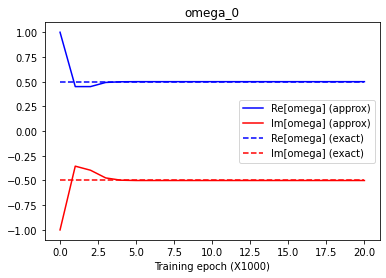 | 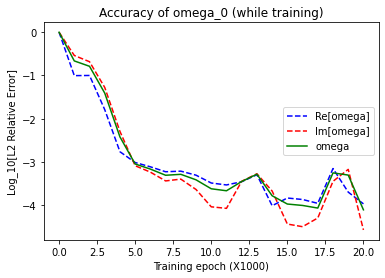
_______________________________________________________________________

2. omega_1 ... L2 relative error (best): 7.33e-04... (at 20000 epochs )

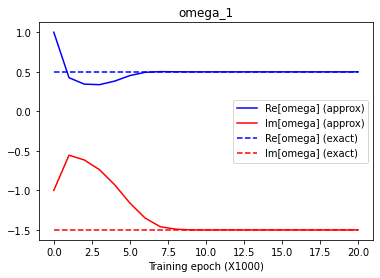 | 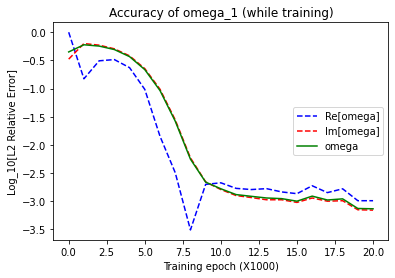

_______________________________________________________________________________

3. omega_2 ... L2 relative error (best): 1.25e-03 ... (at 18000 epochs)

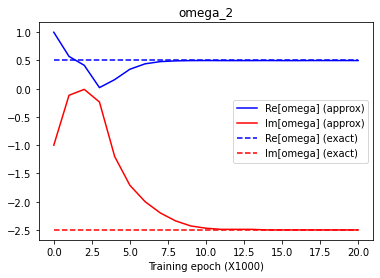 | 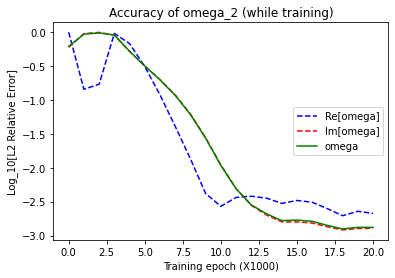

________________________________________________________________________________

4. omega_3 ... L2 relative error (best): 9.61e-03 ... (at 20000 epochs)

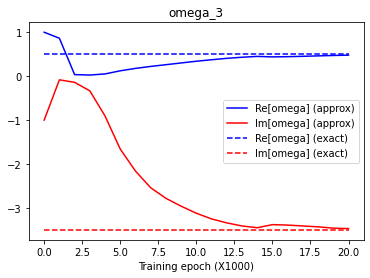 | 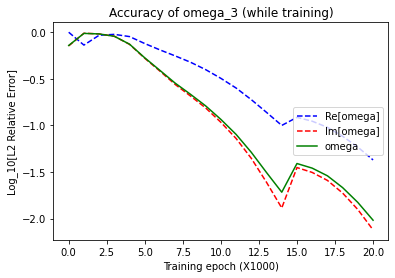

________________________________________________________________________________




Compiling model...
Building feed-forward neural network...
'build' took 0.055024 s

'compile' took 0.937466 s

Initializing variables...
Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [1.18e-01, 2.61e-01, 4.75e+02, 4.75e+02, 2.05e+02, 2.05e+02, 3.25e+01, 1.12e+01]    [1.18e-01, 2.61e-01, 4.75e+02, 4.75e+02, 2.05e+02, 2.05e+02, 3.25e+01, 1.12e+01]    []  
1000      [9.20e-01, 2.88e+00, 1.29e+01, 1.29e+01, 2.62e+00, 2.62e+00, 3.65e+01, 1.92e+01]    [9.20e-01, 2.88e+00, 1.29e+01, 1.29e+01, 2.62e+00, 2.62e+00, 3.65e+01, 1.92e+01]    []  
INFO:tensorflow:/content/model/model.ckpt-1000 is not in all_model_checkpoint_paths. Manually adding it.
2000      [7.82e-01, 1.03e+00, 1.40e+00, 1.40e+00, 5.00e-01, 5.00e-01, 2.73e+01, 1.49e+01]    [7.82e-01, 1.03e+00, 1.40e+00, 1.40e+00, 5.00e-01, 5.00e-01, 2.73e+01, 1.49e+01]    []  


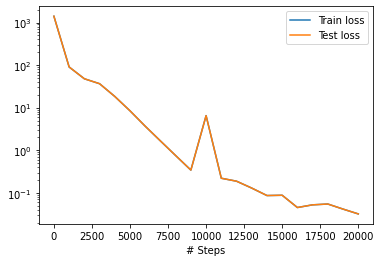

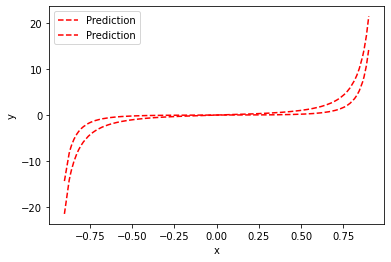

In [5]:
# -*- coding: utf-8 -*-
"""
Created on Sun 09/05/2021
Last updated Tue 11/05/2021

"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import io
import re

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cmath
import math
import deepxde as dde
from deepxde.backend import tf

import matplotlib.pyplot as plt

N = 3
omegaR = tf.Variable(1.0) ### omega = omegaR + omegaI*1j or omega = Re[omega] + Im[omega]*i
omegaI = tf.Variable(-1.0) ### negative sign so that PINN chooses the solution with negative imaginary part (of the two possible solutions for each n)
OmegaR = 0.5 ### true values (not fed into PINN, but used as reference to calculate L2 rel. error)
OmegaI =-3.5

Dom_points = 100
        
def de(y, psi):
        psiR, psiI = psi[:, 0:1], psi[:, 1:2] ### psiR = Re[psi]. psiI = Im[psi]
        dpsiR_y = dde.grad.jacobian(psi, y, i=0)
        dpsiI_y = dde.grad.jacobian(psi, y, i=1)
        dpsiR_yy = dde.grad.hessian(psi, y, component=0, i=0, j=0)
        dpsiI_yy = dde.grad.hessian(psi, y, component=1, i=0, j=0)


        return [((1 - y**2)**2)*dpsiR_yy - 2 * y *(1 - y**2) * dpsiR_y - ((1 - y**2)/2) * psiR - 2*omegaI*omegaR*psiI + (omegaR**2 - omegaI**2)*psiR ,
                ((1 - y**2)**2)*dpsiI_yy - 2 * y *(1 - y**2) * dpsiI_y - ((1 - y**2)/2) * psiI + 2*omegaI*omegaR*psiR + (omegaR**2 - omegaI**2)*psiI ,
                
        ]

### I used Mathematica to check these solutions: i.e. that they give zero on the RHS of the differential equations when plugged in.

def func1(y):### Real part of psi (true solution)
  SolDict = {'N_0' : (1 - y**2)**(-1/4 - 1j/4),
         'N_1' : y*(1 - y**2)**(-3/4 - 1j/4),
         'N_2' : ((3 + 1j)*y**2/(1 - y**2) + 1)*(1 - y**2)**(-1/4 - 1j/4),
         'N_3' : (((5/3 + 1j/3)*y**3)/((1 - y**2)**(3/2)) + y/((1 - y**2)**(1/2)))*(1 - y**2)**(-1/4 - 1j/4)}
        
  sol1 = np.real(SolDict['N_{}'.format(N)])
  return sol1


def func2(y):### Imaginary part of psi (true solution)
  SolDict = {'N_0' : (1 - y**2)**(-1/4 - 1j/4),
         'N_1' : y*(1 - y**2)**(-3/4 - 1j/4),
         'N_2' : ((3 + 1j)*y**2/(1 - y**2) + 1)*(1 - y**2)**(-1/4 - 1j/4),
         'N_3' : (((5/3 + 1j/3)*y**3)/((1 - y**2)**(3/2)) + y/((1 - y**2)**(1/2)))*(1 - y**2)**(-1/4 - 1j/4)}
        
  sol2 = np.imag(SolDict['N_{}'.format(N)])
  return sol2 


def boundary_l(x, on_boundary):
        return on_boundary and np.isclose(x[0], -0.9) 
def boundary_r(x, on_boundary):
        return on_boundary and np.isclose(x[0], 0.9) 

geom = dde.geometry.Interval(-0.9, 0.9) ### Just define a 1D spacial domain

bc1 = dde.DirichletBC(geom, func1, lambda _, boundary_l : boundary_l, component=0) 
bc2 = dde.DirichletBC(geom, func1, lambda _, boundary_r : boundary_r, component=0)
bc3 = dde.DirichletBC(geom, func2, lambda _, boundary_l : boundary_l, component=1) 
bc4 = dde.DirichletBC(geom, func2, lambda _, boundary_r : boundary_r, component=1)

### Solution Dataset (required for inverse problem)

observe_y = np.linspace(-0.9, 0.9, num=50)[:, None]
### [1:] removes -1 (i.e. start point), [:, None] gives column vector form array
psiR = dde.PointSetBC(observe_y, func1(observe_y), component=0)### array of Re[psi] at points observe_y
psiI = dde.PointSetBC(observe_y, func2(observe_y), component=1)### array of Im[psi] at points observe_y

data = dde.data.PDE(
        geom,
        de,
        [bc1, bc2, bc3, bc4, psiR, psiI],
        num_domain=Dom_points,
        num_boundary=2,
        anchors=observe_y,
    )

checkpoint_filepath = "/content/model/model.ckpt"
model_checkpoint_callback = dde.callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,
save_better_only=False,
period=1000)

layer_size = [1] + [20] * 3  + [2]
net = dde.maps.FNN(layer_size, "tanh", "Glorot uniform")
model = dde.Model(data, net)

RE1 = ((OmegaR - omegaR)**2/OmegaR**2)**(1/2)### relative error of Re[omega]
RE2 = ((OmegaI - omegaI)**2/OmegaI**2)**(1/2)### relative error of Im[omega]
ORE = (((OmegaR - omegaR)**2 + (OmegaI - omegaI)**2)/(OmegaR**2 + OmegaI**2))**(1/2)

fnamevar = "omega.dat"
variable = dde.callbacks.VariableValue([omegaR, omegaI, RE1, RE2, ORE], period=1000, filename=fnamevar, precision=7)### For updating omega during training.

model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=20000, callbacks=[model_checkpoint_callback, variable]) 
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

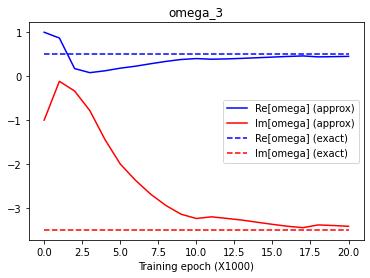

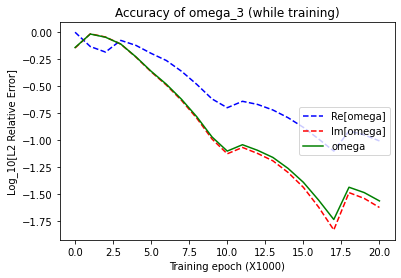

In [6]:
### Plotting omega_n: PINN approximation vs. exact/true solution.
lines = open(fnamevar, "r").readlines()
omega = np.array([np.fromstring(min(re.findall(re.escape('[')+"(.*?)"+re.escape(']'),line), key=len), sep=',') for line in lines])

l,c = omega.shape

plt.plot(range(l),omega[:,0],'b-')
plt.plot(range(l),omega[:,1],'r-')
plt.plot(range(l),np.ones(omega[:,0].shape)*OmegaR,'b--')
plt.plot(range(l),np.ones(omega[:,1].shape)*OmegaI,'r--')
plt.legend(['Re[omega] (approx)','Im[omega] (approx)','Re[omega] (exact)','Im[omega] (exact)'],loc = "right")
plt.title('omega_3')
plt.xlabel('Training epoch (X1000)')
plt.show()

plt.plot(range(l),np.log10(omega[:,2]),'b--')
plt.plot(range(l),np.log10(omega[:,3]),'r--')
plt.plot(range(l),np.log10(omega[:,4]),'g-')
plt.legend(['Re[omega]','Im[omega]','omega'],loc = "right")
plt.xlabel('Training epoch (X1000)')
plt.ylabel('Log_10[L2 Relative Error]')
plt.title('Accuracy of omega_3 (while training)')
plt.show()

Future Considerations:

1. Do I get more accurate QNFs if I reduce the size of the spatial domain?
2. What are the units for omega in this case (include in graph)
.
3. PINN model for n=2 seems to get stuck in local minima a lot compared to other scenarios, so it has to be run several times to get a good approximation. Not clear why. The same issue doesn't occur in the forward problem for n=2.

4. Also include the actual omega values in results.